### Plots from Multiple Runs for Performance Testing

In [ ]:
import glob
import json

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from IPython.display import display

from mfbo4bio import virtual_lab as vl

fidelity_level = [0, 7, 10]
dist = "alpha"
platform_cond = "platform"
clone_representation = "HYBRID3" #"HYBRID2" #"ICM_WRAPPED"
date = "20250804"

def replace_last(lst):
    if isinstance(lst, list) and len(lst) > 0:
        lst[-2] = 10
    return lst

def make_tensor(lst):
    if isinstance(lst, list) and len(lst) > 0:
        #np.array(lst)
        lst = torch.tensor(lst).unsqueeze(0)
    return lst

def experiments(lst):
    result = vl.conduct_experiment(lst, mbr_level=3, clone_distribution=dist)
    return result[0]

def extract_data(file_path):
    best_values = []
    cumulative_cost = []
    fidelities= []
    fidelity_counts = []
    best_points = []

    file_paths = glob.glob(file_path)

    # Loop through files and extract best_values
    for file in file_paths:
        with open(file, "r") as f:
            data = json.load(f)
            best_values.append(data.get("best_values", []))
            cumulative_cost.append(data.get("cumulative_cost_list", []))
            fidelities.append(data.get("fidelities", []))
            best_points.append(data.get("best_points", []))

    df_cumulative_cost = pd.DataFrame(cumulative_cost).fillna(0)
    avg_cumulative_cost = df_cumulative_cost.mean(axis=0)
    std_cumulative_cost = df_cumulative_cost.std(axis=0)

    df_best_points = pd.DataFrame(best_points)
    df_best_points = df_best_points.map(replace_last)
    df_best_points = df_best_points.map(make_tensor)

    df_best_values = df_best_points.map(experiments).cummax(axis=1)

    avg_best_values = df_best_values.mean(axis=0)
    std_best_values = df_best_values.std(axis=0)
    avg_best_values = pd.concat([pd.Series([0]),avg_best_values])
    std_best_values = pd.concat([pd.Series([0]),std_best_values])
    df_fidelities = pd.DataFrame(fidelities).apply(lambda col: col.explode()).fillna(0)

    # Count occurrences of each fidelity level
    fidelity_counts = [list(df_fidelities.apply(
        lambda col: (col == i).sum()).fillna(0).to_numpy(dtype=int)) 
        for i in fidelity_level]

    data = {'best_values_avg': avg_best_values, 
            'best_values_std': std_best_values, 
            'cumulative_cost_avg': avg_cumulative_cost, 
            'cumulative_cost_std': std_cumulative_cost, 
            'fidelity_counts': fidelity_counts}

    return data


GIBBON = extract_data(f"./data/bo/{dist}/gibbon_icm/ \
                      gibbon_icm_native_{clone_representation}_{date}_*.json")
SOBOL = extract_data(f"./data/industrial/{dist}_{platform_cond}/sobol/ \
                     sobol_{20250805}_*.json")
LHS = extract_data(f"./data/industrial/{dist}_{platform_cond}/latin_hypercube/ \
                   lhs_{20250805}_*.json")
factorial = extract_data(f"./data/industrial/{dist}_{platform_cond}/factorial/ \
                         factorial_{20250805}_*.json")
qUCB = extract_data(f"./data/bo/{dist}/qUCB/ \
                    qUCB_{clone_representation}_{date}_*.json")
qLogEI = extract_data(f"./data/bo/{dist}/qLogEI/ \
                      qEI_{clone_representation}_{date}_*.json")
factorial = extract_data(f"./data/industrial/{dist}_platform/sobol/ \
                         sobol_{date}_*.json")


num_iterations = len(GIBBON["best_values_avg"])
max_fidelity_count = max(
    [sum(counts[:num_iterations]) 
     for counts in GIBBON["fidelity_counts"]]) if GIBBON["fidelity_counts"] else 1

output = widgets.Output()

def get_iterations(data_list):
    num_iterations = len(data_list)
    iterations = np.arange(num_iterations)
    return iterations

def plot_results(toggle_GIBBON, toggle_SOBOL, toggle_LHS, toggle_factorial, 
                 toggle_qUCB, toggle_qLogEI, mbr_level=7):
    with output:
        output.clear_output(wait=True)
        plt.close('all')

        fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(20, 6), sharex=False)

        plt.title("Best Values and Fidelity Distribution Over Iterations")

        ax1.set_ylabel("Product (mg/L)", fontsize=14)
        ax1.set_xlabel("Iterations", fontsize=14)
        ax1.set_xlim(0, 21)
        ax1.grid(True)
        ax1.set_title(f"Best Projected Values Over Iterations \
                      (Distribution {dist[0].capitalize()})", fontsize=18)

        if toggle_GIBBON:
            ax1.plot(get_iterations(GIBBON["best_values_avg"]), 
                    GIBBON["best_values_avg"], label='GIBBON', 
                    color='blue', linestyle='-', marker='o')
            ax1.fill_between(get_iterations(GIBBON["best_values_avg"]), 
                            GIBBON["best_values_avg"]-GIBBON["best_values_std"], 
                            GIBBON["best_values_avg"]+GIBBON["best_values_std"], 
                            color="blue", alpha=0.2)
            
        if toggle_qUCB:
            ax1.plot(get_iterations(qUCB["best_values_avg"]),
                    qUCB["best_values_avg"], label='qUCB', 
                            color='magenta', linestyle='-', marker='o')
            ax1.fill_between(get_iterations(qUCB["best_values_avg"]),
                            qUCB["best_values_avg"]-qUCB["best_values_std"], 
                            qUCB["best_values_avg"]+qUCB["best_values_std"], 
                            color="magenta", alpha=0.2)
        
        if toggle_qLogEI:
            ax1.plot(get_iterations(qLogEI["best_values_avg"]),
                    qLogEI["best_values_avg"], label='qLogEI', 
                            color='brown', linestyle='-', marker='o')
            ax1.fill_between(get_iterations(qLogEI["best_values_avg"]),
                            qLogEI["best_values_avg"]-qLogEI["best_values_std"], 
                            qLogEI["best_values_avg"]+qLogEI["best_values_std"], 
                            color="brown", alpha=0.2)

        if toggle_SOBOL:
            ax1.plot(get_iterations(SOBOL["best_values_avg"]), 
                    SOBOL["best_values_avg"], 
                    label='Standard Industrial Approach (SOBOL)', 
                            color='green', linestyle='-', marker='o')
            ax1.fill_between(get_iterations(SOBOL["best_values_avg"]), 
                            SOBOL["best_values_avg"]-SOBOL["best_values_std"], 
                            SOBOL["best_values_avg"]+SOBOL["best_values_std"], 
                            color="green", alpha=0.2)
            
        if toggle_LHS:
            ax1.plot(get_iterations(LHS["best_values_avg"]), 
                    LHS["best_values_avg"], 
                    label='Standard Industrial Approach (LHS)', 
                    color='orange', linestyle='-', marker='o')
            ax1.fill_between(get_iterations(LHS["best_values_avg"]), 
                            LHS["best_values_avg"]-LHS["best_values_std"], 
                            LHS["best_values_avg"]+LHS["best_values_std"], 
                            color="orange", alpha=0.2)
            
        if toggle_factorial:
            ax1.plot(get_iterations(factorial["best_values_avg"]), 
                    factorial["best_values_avg"], 
                    label='Standard Industrial Approach (Factorial)', 
                    color='red', linestyle='-', marker='o')
            ax1.fill_between(get_iterations(factorial["best_values_avg"]), 
                            factorial["best_values_avg"]-factorial["best_values_std"], 
                            factorial["best_values_avg"]+factorial["best_values_std"], 
                            color="red", alpha=0.2)
        
        if toggle_GIBBON:
            ax3.plot(GIBBON["cumulative_cost_avg"][:22], 
                    GIBBON["best_values_avg"][:22], label='GIBBON', 
                    color='blue', linestyle='-', marker='s')

            ax3.fill_between(GIBBON["cumulative_cost_avg"][:22],
                            GIBBON["best_values_avg"][:22]-GIBBON["best_values_std"][:22], 
                            GIBBON["best_values_avg"][:22]+GIBBON["best_values_std"][:22], 
                            color="blue", alpha=0.2)
            
        if toggle_qUCB:
            ax3.plot(qUCB["cumulative_cost_avg"][:22], qUCB["best_values_avg"][:22], 
                    label='qUCB', 
                    color='magenta', linestyle='-', marker='s')

            ax3.fill_between(qUCB["cumulative_cost_avg"][:22], 
                            qUCB["best_values_avg"][:22]-qUCB["best_values_std"][:22], 
                            qUCB["best_values_avg"][:22]+qUCB["best_values_std"][:22], 
                            color="magenta", alpha=0.2)
            
        if toggle_qLogEI:
            ax3.plot(qLogEI["cumulative_cost_avg"][:22], 
                    qLogEI["best_values_avg"][:22], label='qLogEI', 
                    color='brown', linestyle='-', marker='s')

            ax3.fill_between(qLogEI["cumulative_cost_avg"][:22], 
                            qLogEI["best_values_avg"][:22]-qLogEI["best_values_std"][:22], 
                            qLogEI["best_values_avg"][:22]+qLogEI["best_values_std"][:22], 
                            color="brown", alpha=0.2)
        
        if toggle_SOBOL:
            ax3.plot(SOBOL["cumulative_cost_avg"][:22], 
                    SOBOL["best_values_avg"][:22], 
                    label='Standard Industrial Approach (SOBOL)', 
                    color='green', linestyle='-', marker='s')

            ax3.fill_between(SOBOL["cumulative_cost_avg"][:22], 
                            SOBOL["best_values_avg"][:22]-SOBOL["best_values_std"][:22], 
                            SOBOL["best_values_avg"][:22]+SOBOL["best_values_std"][:22], 
                            color="green", alpha=0.2)

        if toggle_LHS:
            ax3.plot(LHS["cumulative_cost_avg"][:22], 
                    LHS["best_values_avg"][:22], 
                    label='Standard Industrial Approach (LHS)', 
                    color='orange', linestyle='-', marker='s')

            ax3.fill_between(LHS["cumulative_cost_avg"][:22], 
                            LHS["best_values_avg"][:22]-LHS["best_values_std"][:22], 
                            LHS["best_values_avg"][:22]+LHS["best_values_std"][:22],
                            color="orange", alpha=0.2)
        
        if toggle_factorial:
            ax3.plot(factorial["cumulative_cost_avg"][:22], 
                    factorial["best_values_avg"][:22], 
                    label='Standard Industrial Approach (Factorial)', 
                    color='red', linestyle='-', marker='s')

            ax3.fill_between(factorial["cumulative_cost_avg"][:22], 
                            factorial["best_values_avg"][:22]-factorial["best_values_std"][:22], 
                            factorial["best_values_avg"][:22]+factorial["best_values_std"][:22], 
                            color="red", alpha=0.2)

        ax3.set_xlabel("Cumulative Costs (€)", fontsize=14)
        ax3.set_ylabel("Product (mg/L)", fontsize=14)
        ax1.tick_params(axis='both', labelsize=12)
        ax3.tick_params(axis='both', labelsize=12)

        ax3.grid(True)
        ax3.set_title(f"Best Projected Values Over Cumulative \
                      Cost (Distribution {dist[0].capitalize()})", fontsize=18)
        ax3.legend(loc="lower right", fontsize=12)
        ax1.legend(loc="lower right", fontsize=12)
        
        plt.tight_layout()
        #plt.savefig(fname=f"plots/dist_{dist[0].capitalize()}_mbr_{mbr_level}.pdf")
        plt.show()

# UI-Widgets
toggle_GIBBON = widgets.Checkbox(value=True, description="GIBBON")
toggle_SOBOL = widgets.Checkbox(value=True, description="SOBOL")
toggle_LHS = widgets.Checkbox(value=True, description="LHS")
toggle_factorial = widgets.Checkbox(value=True, description="Factorial")
toggle_qUCB = widgets.Checkbox(value=True, description="qUCB")
toggle_qLogEI = widgets.Checkbox(value=True, description="qLogEI")

def update_plot(_):
    plot_results(toggle_GIBBON.value, toggle_SOBOL.value, toggle_LHS.value, 
                 toggle_factorial.value, toggle_factorial.value, toggle_qUCB.value, 
                 toggle_qLogEI.value, mbr_level=fidelity_level[1])


toggle_GIBBON.observe(update_plot, names='value')
toggle_qLogEI.observe(update_plot, names='value')
toggle_SOBOL.observe(update_plot, names='value')
toggle_LHS.observe(update_plot, names='value')
toggle_factorial.observe(update_plot, names='value')
toggle_qUCB.observe(update_plot, names='value')

display(widgets.VBox([toggle_GIBBON, toggle_SOBOL, toggle_LHS, toggle_factorial, 
                      toggle_factorial, toggle_qUCB, toggle_qLogEI, output]))
plot_results(True, True, True, True, True, True, True, mbr_level=fidelity_level[1])


## Embedding vs. ICM

In [ ]:
from matplotlib import cm

dist = "alpha"
date = "20250804"

# Load experiment results
def extract_data(file_path, fidelity_level=[0, 7, 10], dist=dist):
    #print(file_path)
    def replace_last(lst):
        if isinstance(lst, list) and len(lst) > 0:
            lst[-2] = 10
        return lst

    def make_tensor(lst):
        if isinstance(lst, list) and len(lst) > 0:
            lst = torch.tensor(lst).unsqueeze(0)
        return lst

    def experiments(lst):
        import vlab as vl
        result = vl.conduct_experiment(lst, mbr_level=7, clone_distribution=dist)
        return result[0]

    best_values = []
    cumulative_cost = []
    fidelities = []
    best_points = []

    file_paths = glob.glob(file_path)
    for file in file_paths:
        with open(file, "r") as f:
            data = json.load(f)
            best_values.append(data.get("best_values", []))
            cumulative_cost.append(data.get("cumulative_cost_list", []))
            fidelities.append(data.get("fidelities", []))
            best_points.append(data.get("best_points", []))


    df_cumulative_cost = pd.DataFrame(cumulative_cost).fillna(0)
    avg_cumulative_cost = df_cumulative_cost.mean(axis=0)
    std_cumulative_cost = df_cumulative_cost.std(axis=0)

    df_best_points = pd.DataFrame(best_points)
    df_best_points = df_best_points.map(replace_last)
    df_best_points = df_best_points.map(make_tensor)
    df_best_values = df_best_points.map(experiments).cummax(axis=1)

    avg_best_values = df_best_values.mean(axis=0)
    std_best_values = df_best_values.std(axis=0)

    avg_best_values = pd.concat([pd.Series([0]), avg_best_values])
    std_best_values = pd.concat([pd.Series([0]), std_best_values])

    return {
        'avg_best_values': avg_best_values,
        'std_best_values': std_best_values,
        'avg_cumulative_cost': avg_cumulative_cost,
        'std_cumulative_cost': std_cumulative_cost
    }

# Industrial variants to compare
industrial_variants = {
    "GIBBON": {
        "ICM": f"./data/bo/{dist}/gibbon_icm/ \
        gibbon_icm_native_ICM_WRAPPED_{date}_*.json",
        "Entity Embedding (2D)": f"./data/bo/{dist}/gibbon_icm/ \
        gibbon_icm_native_HYBRID2_{date}_*.json",
        "Entity Embedding (3D)": f"./data/bo/{dist}/gibbon_icm/ \
        gibbon_icm_native_HYBRID3_{date}_*.json",
    },
    "qLogEI": {
        "ICM": f"./data/bo/{dist}/qLogEI/qEI_ICM_WRAPPED_{date}_*.json",
        "Entity Embedding (2D)": f"./data/bo/{dist}/qLogEI/ \
        qEI_HYBRID2_{date}_*.json",
        "Entity Embedding (3D)": f"./data/bo/{dist}/qLogEI/ \
        qEI_HYBRID3_{date}_*.json",
    },
    "qUCB": {
        "ICM": f"./data/bo/{dist}/qUCB/qUCB_ICM_WRAPPED_{date}_*.json",
        "Entity Embedding (2D)": f"./data/bo/{dist}/qUCB/ \
        qUCB_HYBRID2_{date}_*.json",
        "Entity Embedding (3D)": f"./data/bo/{dist}/qUCB/ \
        qUCB_HYBRID3_{date}_*.json",
}
}

# Colormaps
base_colors = {
    "GIBBON": cm.Greens,
    "qLogEI": cm.Blues,
    "qUCB": cm.Reds,
}

def plot_industrial_variants_row(data_dict):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    for idx, (method, variants) in enumerate(data_dict.items()):
        ax = axs[idx]
        color_map = base_colors[method]
        n = len(variants)

        for v_idx, (variant_name, data) in enumerate(variants.items()):
            color = color_map(0.3 + (v_idx + 1) / (n + 1))
            label = f"{variant_name}"

            iterations = np.arange(len(data["avg_best_values"]))
            print(f"""{label}: {data["avg_best_values"].iloc[-1]}""")
            ax.plot(iterations, data["avg_best_values"], 
                    label=label, color=color, marker="s")
            ax.fill_between(iterations,
                            data["avg_best_values"] - data["std_best_values"],
                            data["avg_best_values"] + data["std_best_values"],
                            color=color, alpha=0.2)

        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_title(f"{method} Variants Distribution", fontsize=18)
        ax.set_xlabel("Iterations", fontsize=14)
        if idx == 0:
            ax.set_ylabel("Product (mg/L)", fontsize=14)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.savefig(f"plots/clone_representation_{dist}.pdf")
    plt.show()

# Load and process all variant data
processed_data = {
    method: {
        variant: extract_data(path)
        for variant, path in variants.items()
    }
    for method, variants in industrial_variants.items()
}

# Plot
plot_industrial_variants_row(processed_data)

### Fidelity Distribution Plots

Attempting to load data from: ./data/bo/alpha/qUCB/qUCB_HYBRID3_20250804_*.json
Attempting to load data from: ./data/bo/beta/qUCB/qUCB_HYBRID3_20250721_*.json


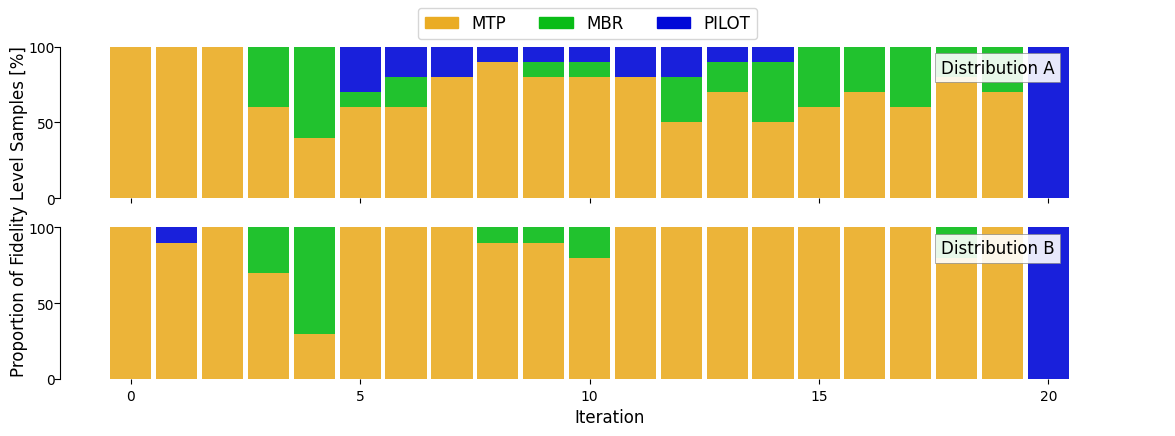

In [ ]:

def extract_data(file_path):
    """
    Extracts best values, cumulative cost, fidelities, 
    and best points from JSON files. Calculates average cumulative cost 
    and counts of each fidelity level over iterations.
    """
    best_values = []
    cumulative_cost = []
    fidelities = []
    best_points = []

    file_paths = glob.glob(file_path)

    for file in file_paths:
        with open(file, "r") as f:
            data = json.load(f)
            best_values.append(data.get("best_values", []))
            cumulative_cost.append(data.get("cumulative_cost_list", []))
            fidelities.append(data.get("fidelities", []))
            best_points.append(data.get("best_points", []))

    df_cumulative_cost = pd.DataFrame(cumulative_cost).fillna(0)
    avg_cumulative_cost = df_cumulative_cost.mean(axis=0)

    df_fidelities = pd.DataFrame(fidelities).apply(lambda col: col.explode()).fillna(0)

    possible_levels = [0, 3, 5, 7, 10]
    fidelity_counts = {}
    for level in possible_levels:
        fidelity_counts[level] = list(df_fidelities.apply(
            lambda col: (col == level).sum()).fillna(0).to_numpy(dtype=int))

    return {
        'cumulative_cost_avg': avg_cumulative_cost,
        'fidelity_counts': fidelity_counts,
    }

clone_distributions = ["alpha", "beta"]
mbr_levels = [7]
bar_colors = {0: "#EAAC23", 
              3: "#09BC17", 
              5: "#09BC17", 
              7: "#09BC17", 
              10: "#0008D8"}

distribution_dates = {
    "alpha": "20250804", 
    "beta": "20250721"   
}

fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharex=True)
axes = axes.flatten()

for idx, dist in enumerate(clone_distributions):
    ax = axes[idx]
    mbr = mbr_levels[0]

    current_date = distribution_dates.get(dist, "20250804") 

    file_pattern = f"./data/bo/{dist}/qUCB/qUCB_HYBRID3_{current_date}_*.json"
    print(f"Attempting to load data from: {file_pattern}") 

    try:
        data = extract_data(file_pattern)
    except Exception as e:
        print(f"Error loading data for MBR={mbr}, \
              dist={dist} with pattern {file_pattern}: {e}")
        continue 

    num_iterations = len(data['cumulative_cost_avg'])

    if dist == "beta" and num_iterations > 21:
        num_iterations = 21
        for key in data['fidelity_counts']:
            data['fidelity_counts'][key] = data['fidelity_counts'][key][:num_iterations]
        data['cumulative_cost_avg'] = data['cumulative_cost_avg'][:num_iterations]

    fidelity_levels = [0, mbr, 10]
    counts_matrix = []

    for level in fidelity_levels:
        counts = np.array(data['fidelity_counts'].get(level, []))
        counts = np.pad(counts, (0, num_iterations - len(counts)), 'constant')
        counts_matrix.append(counts)

    counts_matrix = np.vstack(counts_matrix)
    total_counts = np.sum(counts_matrix, axis=0)
    total_counts[total_counts == 0] = 1

    proportions = counts_matrix / total_counts * 100

    bottom = np.zeros(num_iterations)
    for i, level in enumerate(fidelity_levels):
        ax.bar(np.arange(num_iterations), proportions[i], bottom=bottom,
               color=bar_colors[level], alpha=0.9, width=0.9)
        bottom += proportions[i] 

    ax.set_ylim(0, 100)
    ax.set_yticks([0, 50, 100])
    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.spines['left'].set_visible(True)
    ax.tick_params(axis='y', pad=0, length=4) 
    for spine_name, spine in ax.spines.items():
        if spine_name != 'left':
            spine.set_visible(False)

    bbox_props = dict(fc="white", ec="0.5", lw=0.5, alpha=0.9)
    if dist == "alpha":
        ax.text(0.9, 0.8, "Distribution A", transform=ax.transAxes,
                ha='right', va='bottom', fontsize=12, bbox=bbox_props)
    elif dist == "beta":
        ax.text(0.9, 0.8, "Distribution B", transform=ax.transAxes,
                ha='right', va='bottom', fontsize=12, bbox=bbox_props)

fig.supxlabel("Iteration", fontsize=12, y=0.15, x=0.52) # y adjusts vertical position
fig.supylabel("Proportion of Fidelity Level Samples [%]", fontsize=12, x=0.12, y=0.58) 

handles = [plt.Rectangle((0, 0), 1, 1, color=bar_colors[lvl]) for lvl in [0, 7, 10]]
labels = ["MTP", "MBR", "PILOT"]
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=12)

plt.tight_layout(rect=[0.1, 0.1, 0.9, 0.95])

#plt.savefig("plots/fidelity_distribution_qUCB.pdf")
plt.show()
